In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [3]:
import sys
sys.path.append('/home/equon/a2e-mmc')

In [4]:
from mmctools.dataloaders import read_dir
from mmctools.wrf.utils import extract_column_from_wrfdata
from mmctools.coupling.sowfa import InternalCoupling
from mmctools.helper_functions import calc_wind

In [22]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [35]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Define some physical constants

In [6]:
g  = 9.81            # Gravity [m s-2]
T0 = 300             # Reference temperature for perturbation temperature [K]
K  = 0.41            # von Karman constant
R_air = 287.058      # Specific gas constant for dry air [J kg-1 K-1]
Cp_air = 1005        # Specific heat of air [J kg-1 K-1]
P0 = 100000          # Reference pressure [Pa]
kappa = R_air/Cp_air # Poisson constant

# Extract WRF data at a specific site and write as internal forcing for SOWFA

Input files

In [7]:
dpath = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/'
file_filter  = 'mmc_d03_*'

SWIFT site coordinates

In [8]:
site_latitude  = 33.61054
site_longitude = -102.05054

Some parameters for extracting site data

In [9]:
# Define how WRF data is filtered to site specific data
# - 'interpolate': interpolate to site coordinates
# - 'nearest': use nearest WRF grid point
# - 'average': average of an area L_filter x Lfilter centred around the site
spatial_filter = 'interpolate'
L_filter = 0.0

# Define microscale vertical grid
Ztop = 2000.0 # Column height [m]
Vres = 5.0    # Vertical resolution [m]

Output file to save WRF data at SWiFT site for later data analysis

In [10]:
output = 'WRF_20131108-09.nc'

## Load data
WRF column data calculated by `assessment/studies/coupling_comparison/preprocessing/internal/wrf_to_sowfa.ipynb`

In [11]:
%%time
ds = xr.open_dataset(output)

CPU times: user 14.7 ms, sys: 2.43 ms, total: 17.2 ms
Wall time: 25 ms


## Write SOWFA data
sanity check that InternalCoupling.write_\*() routines produce identical output

In [12]:
dateref = '2013-11-08 00:00:00'
datefrom = '2013-11-08 12:00:00'
dateto = '2013-11-09 12:00:00'

In [13]:
dirout = 'drivingData/wrf/'

### initial conditions, source terms

In [14]:
# Generate dataframe with U, V, W, theta and their tendencies
ds['FU'] = ds['RU_TEND_PGF'] + ds['RU_TEND_ADV']
ds['FV'] = ds['RV_TEND_PGF'] + ds['RV_TEND_ADV']

df = ds.to_dataframe().loc[:,['U','V','W','theta','FU','FV','T_TEND_ADV']].reset_index()
df.rename(index=str, columns={"Time": "datetime"},inplace=True)
df.set_index('datetime',inplace=True)

In [15]:
%%time
to_sowfa = InternalCoupling(dirout,df,dateref,datefrom,dateto)
to_sowfa.write_ICs('initialValues',xmom='U',ymom='V',temp='theta')
to_sowfa.write_timeheight('fieldTable',xmom='U',ymom='V',zmom='W',temp='theta')
to_sowfa.write_timeheight('forcingTable',xmom='FU',ymom='FV',zmom='FW',temp='T_TEND_ADV')
#Note: FW does not exist so will be set to zero

CPU times: user 9.26 s, sys: 138 ms, total: 9.4 s
Wall time: 357 ms


### surface forcing

In [16]:
# Generate dataframe with surface parameters
df_bc = ds.to_dataframe().loc[:,['TSK','T2','thetaSK','theta2','wt']].reset_index()
df_bc.rename(index=str, columns={"Time": "datetime"},inplace=True)
df_bc.set_index('datetime',inplace=True)
df_bc = df_bc.loc[df_bc.height==0].copy()

In [17]:
%%time
to_sowfabc = InternalCoupling(dirout,df_bc,dateref,datefrom,dateto)
to_sowfabc.write_BCs('surfaceSkinTemperatureTable',fieldname='TSK')
to_sowfabc.write_BCs('surface2mTemperatureTable',fieldname='T2')
to_sowfabc.write_BCs('surfaceSkinPotentialTemperatureTable',fieldname='thetaSK')
to_sowfabc.write_BCs('surface2mPotentialTemperatureTable',fieldname='theta2')
to_sowfabc.write_BCs('surfaceTemperatureFluxTable',fieldname='wt',fact=-1.0)

CPU times: user 724 ms, sys: 14.1 ms, total: 738 ms
Wall time: 22.3 ms


## Check different tendencies

In [51]:
# pressure gradient estimated directly from reconstructed WRF 4D field (x,y,z,t)
gradp = pd.read_csv('/projects/mmc/equon/SWIFTRegion/wrf_to_sowfa/data/gradp.csv')
gradp['datetime'] = pd.to_datetime(gradp['datetime'])
gradp.set_index(['datetime','height'], inplace=True)

In [29]:
driving_terms = ds[['FU','FV','RU_TEND_PGF','RV_TEND_PGF','RU_TEND_ADV','RV_TEND_ADV']].to_dataframe()

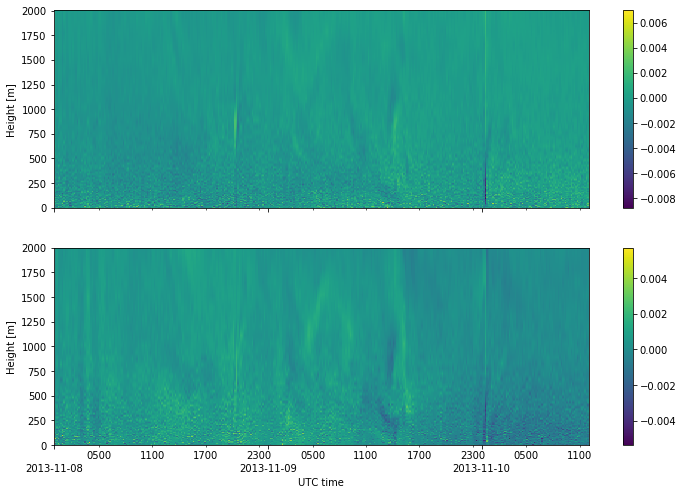

In [30]:
fig,ax,cbars = plot_timeheight(driving_terms,
                               fields=['FU','FV'],
                              )

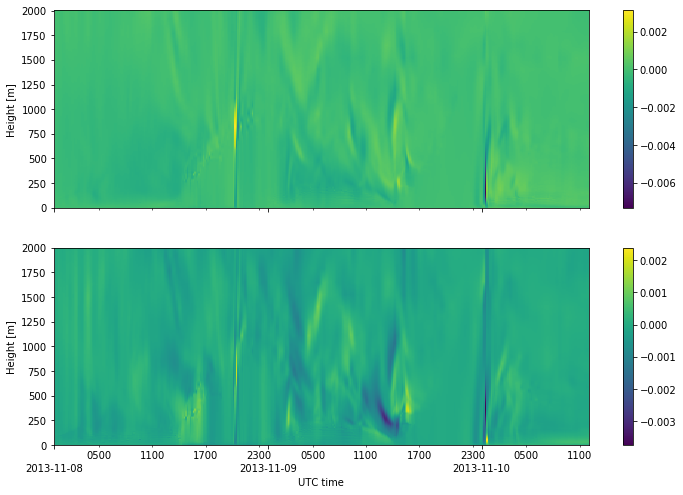

In [31]:
fig,ax,cbars = plot_timeheight(driving_terms,
                               fields=['RU_TEND_ADV','RV_TEND_ADV'],
                              )

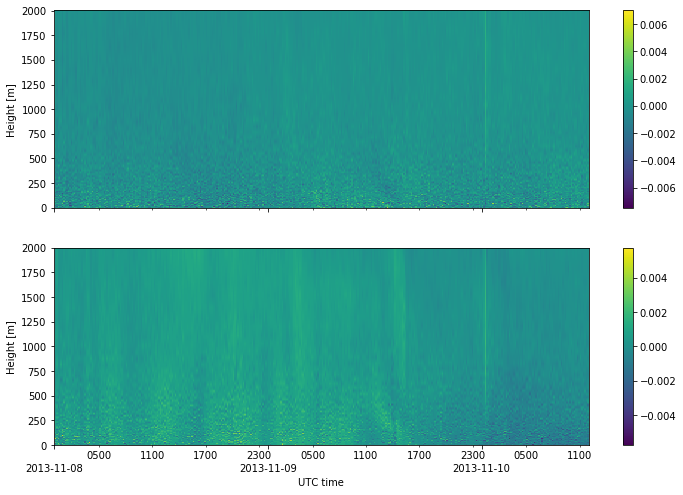

In [32]:
fig,ax,cbars = plot_timeheight(driving_terms,
                               fields=['RU_TEND_PGF','RV_TEND_PGF'],
#                                fieldlimits={
#                                    'RU_TEND_PGF': (0.007,0.012),
#                                    'RV_TEND_PGF': (-0.010,-0.006),
#                                },
                              )

In [41]:
ax0.get_legend_handles_labels?

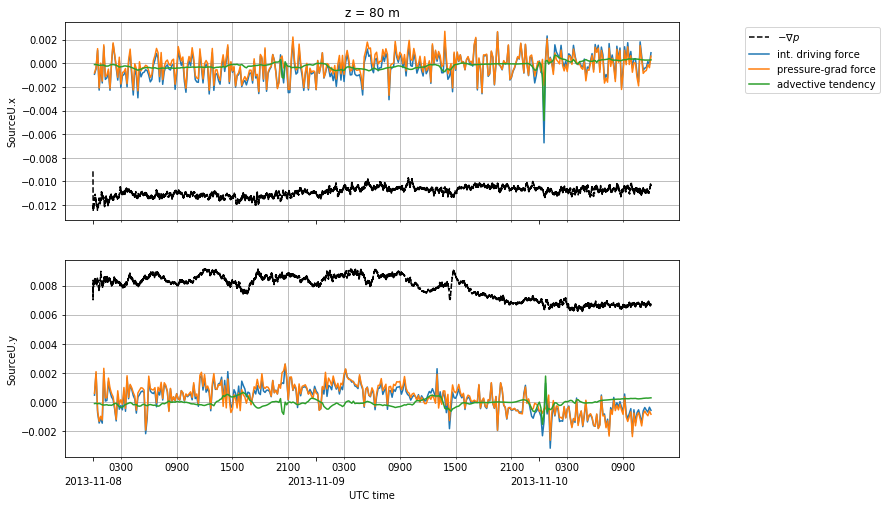

In [64]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
selected_height = 80.

#ax2 = [axi.twinx() for axi in ax]
_,_ = plot_timehistory_at_height(-gradp,
                                 fields=['dpdx','dpdy'],
                                 heights=selected_height,
                                 fig=fig,ax=ax,
                                 color='k', linestyle='--',
                                )

_,_ = plot_timehistory_at_height(driving_terms,
                                    fields=['FU','FV'],
                                    heights=selected_height,
                                    fig=fig,ax=ax,
                                    color=colors[0],
                                   )
_,_ = plot_timehistory_at_height(driving_terms,
                                 fields=['RU_TEND_PGF','RV_TEND_PGF'],
                                 heights=selected_height,
                                 fig=fig,ax=ax,
                                 color=colors[1],
                                )
_,_ = plot_timehistory_at_height(driving_terms,
                                 fields=['RU_TEND_ADV','RV_TEND_ADV'],
                                 heights=selected_height,
                                 fig=fig,ax=ax,
                                 color=colors[2],
                                )

ax[0].set_title('z = {:g} m'.format(selected_height))
ax[0].set_ylabel('SourceU.x')
ax[1].set_ylabel('SourceU.y')
# ax2[0].set_ylabel('-dp/dx')
# ax2[1].set_ylabel('-dp/dy')
lgd = ax[0].legend(ax[0].get_lines(), #ax2[0].get_lines() + ax[0].get_lines(),
                   [
                       r'$-\nabla p$',
                       'int. driving force',
                       'pressure-grad force',
                       'advective tendency',
                   ],
                   loc='upper left', bbox_to_anchor=(1.1,1))